# Homework Module 1 LLM Zoomcamp

In [3]:
# To answer Q6
# !pip install tiktoken

In [1]:
import numpy as np
import pandas as pd

# Q1 

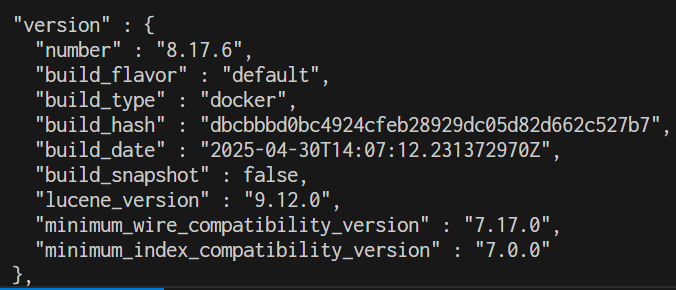

What's the version.build_hash value?
`dbcbbbd0bc4924cfeb28929dc05d82d662c527b7`

# Q2
Now let's get the FAQ data. You can run this snippet:
```
import requests 

docs_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main/01-intro/documents.json?raw=1'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

documents = []

for course in documents_raw:
    course_name = course['course']

    for doc in course['documents']:
        doc['course'] = course_name
        documents.append(doc)
```
Note that you need to have the requests library:
```
pip install requests
```

***Indexing the data***

Index the data in the same way as was shown in the course videos. Make the course field a keyword and the rest should be text.

Don't forget to install the ElasticSearch client for Python:
```
pip install elasticsearch
```
Which function do you use for adding your data to elastic?

- insert
- **index**
- put
- add

In [4]:
import requests 

docs_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main/01-intro/documents.json?raw=1'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

documents = []

for course in documents_raw:
    course_name = course['course']

    for doc in course['documents']:
        doc['course'] = course_name
        documents.append(doc)

In [6]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp'}

In [7]:
from elasticsearch import Elasticsearch

In [9]:
es_client = Elasticsearch('http://localhost:9200')
es_client.info()

ObjectApiResponse({'name': 'ee6523bb10fb', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'iI7iCK-iQqyWvSPoepSIhQ', 'version': {'number': '8.17.6', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': 'dbcbbbd0bc4924cfeb28929dc05d82d662c527b7', 'build_date': '2025-04-30T14:07:12.231372970Z', 'build_snapshot': False, 'lucene_version': '9.12.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [10]:
# Create index for the documents
from tqdm.auto import tqdm

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"} 
        }
    }
}

index_name = "course-questions"
try:
    es_client.indices.create(index=index_name, body = index_settings)
except:
    pass

In [11]:
for doc in tqdm(documents):
    es_client.index(index=index_name, document=doc)

  0%|          | 0/948 [00:00<?, ?it/s]

# Q3
**Searching**

Now let's search in our index.

We will execute a query "How do execute a command on a Kubernetes pod?".

Use only question and text fields and give question a boost of 4, and use "type": "best_fields".

What's the score for the top ranking result?

- 84.50
- 64.50
- **44.50**
- 24.50

Look at the _score field.

In [13]:
query = "How do execute a command on a Kubernetes pod?"
print(query)

How do execute a command on a Kubernetes pod?


In [14]:
search_query = {
    "size": 1,
    "query": {
        "bool": {
            "must": {
                "multi_match": {
                    "query": query,
                    "fields": ["question^4", "text"],
                    "type": "best_fields"
                }
            }
        }
    }
}

In [15]:
response = es_client.search(index=index_name, body=search_query)

In [18]:
print(response)

{'took': 160, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 739, 'relation': 'eq'}, 'max_score': 44.50556, 'hits': [{'_index': 'course-questions', '_id': 'DwxLVZcBT2Fg5OE7NxOF', '_score': 44.50556, '_source': {'text': 'Launch the container image in interactive mode and overriding the entrypoint, so that it starts a bash command.\ndocker run -it --entrypoint bash <image>\nIf the container is already running, execute a command in the specific container:\ndocker ps (find the container-id)\ndocker exec -it <container-id> bash\n(Marcos MJD)', 'section': '5. Deploying Machine Learning Models', 'question': 'How do I debug a docker container?', 'course': 'machine-learning-zoomcamp'}}]}}


# Q4
**Filtering**

Now ask a different question: "How do copy a file to a Docker container?".

This time we are only interested in questions from machine-learning-zoomcamp.

Return 3 results. What's the 3rd question returned by the search engine?

- How do I debug a docker container?
- **How do I copy files from a different folder into docker container’s working directory?**
- How do Lambda container images work?
- How can I annotate a graph?

In [19]:
query = "How do copy a file to a Docker container?"
print(query)

How do copy a file to a Docker container?


In [20]:
search_query = {
    "size": 3,
    "query": {
        "bool": {
            "must": {
                "multi_match": {
                    "query": query,
                    "fields": ["question^4", "text"],
                    "type": "best_fields"
                }
            },
            "filter": {
                "term": {
                    "course": "machine-learning-zoomcamp"
                }
            }
        }
    }
}

In [21]:
response_q4 = es_client.search(index=index_name, body=search_query)

In [23]:
print(response_q4)

{'took': 46, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 340, 'relation': 'eq'}, 'max_score': 73.38676, 'hits': [{'_index': 'course-questions', '_id': 'DwxLVZcBT2Fg5OE7NxOF', '_score': 73.38676, '_source': {'text': 'Launch the container image in interactive mode and overriding the entrypoint, so that it starts a bash command.\ndocker run -it --entrypoint bash <image>\nIf the container is already running, execute a command in the specific container:\ndocker ps (find the container-id)\ndocker exec -it <container-id> bash\n(Marcos MJD)', 'section': '5. Deploying Machine Learning Models', 'question': 'How do I debug a docker container?', 'course': 'machine-learning-zoomcamp'}}, {'_index': 'course-questions', '_id': 'LgxLVZcBT2Fg5OE7OBMV', '_score': 66.688705, '_source': {'text': "You can copy files from your local machine into a Docker container using the docker cp command. Here's how to do it:\nTo copy a file or dire

In [24]:
result_docs = []
for hit in response_q4['hits']['hits']:
    result_docs.append(hit['_source'])

In [25]:
result_docs

[{'text': 'Launch the container image in interactive mode and overriding the entrypoint, so that it starts a bash command.\ndocker run -it --entrypoint bash <image>\nIf the container is already running, execute a command in the specific container:\ndocker ps (find the container-id)\ndocker exec -it <container-id> bash\n(Marcos MJD)',
  'section': '5. Deploying Machine Learning Models',
  'question': 'How do I debug a docker container?',
  'course': 'machine-learning-zoomcamp'},
 {'text': "You can copy files from your local machine into a Docker container using the docker cp command. Here's how to do it:\nTo copy a file or directory from your local machine into a running Docker container, you can use the `docker cp command`. The basic syntax is as follows:\ndocker cp /path/to/local/file_or_directory container_id:/path/in/container\nHrithik Kumar Advani",
  'section': '5. Deploying Machine Learning Models',
  'question': 'How do I copy files from my local machine to docker container?',
 

# Q5

Now we're ready to build a prompt to send to an LLM.

Take the records returned from Elasticsearch in Q4 and use this template to build the context. Separate context entries by two linebreaks (\n\n)
```
context_template = """
Q: {question}
A: {text}
""".strip()
```
Now use the context you just created along with the "How do I execute a command in a running docker container?" question to construct a prompt using the template below:
```
prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT:
{context}
""".strip()
```
What's the length of the resulting prompt? (use the len function)

- 946
- **1446**
- 1946
- 2446

In [26]:
query = "How do I execute a command in a running docker container?"
print(query)

How do I execute a command in a running docker container?


In [30]:
context = ""
for doc in result_docs:
    context_template = """
Q: {question}
A: {text}
""".strip()

    new_context = context_template.format(question=doc['question'], text=doc['text'])
    context = context + new_context + "\n\n"

In [31]:
print(context)

Q: How do I debug a docker container?
A: Launch the container image in interactive mode and overriding the entrypoint, so that it starts a bash command.
docker run -it --entrypoint bash <image>
If the container is already running, execute a command in the specific container:
docker ps (find the container-id)
docker exec -it <container-id> bash
(Marcos MJD)

Q: How do I copy files from my local machine to docker container?
A: You can copy files from your local machine into a Docker container using the docker cp command. Here's how to do it:
To copy a file or directory from your local machine into a running Docker container, you can use the `docker cp command`. The basic syntax is as follows:
docker cp /path/to/local/file_or_directory container_id:/path/in/container
Hrithik Kumar Advani

Q: How do I copy files from a different folder into docker container’s working directory?
A: You can copy files from your local machine into a Docker container using the docker cp command. Here's how to 

In [32]:
prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT:
{context}
""".strip()

prompt = prompt_template.format(question=query, context=context)
print(prompt)

You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: How do I execute a command in a running docker container?

CONTEXT:
Q: How do I debug a docker container?
A: Launch the container image in interactive mode and overriding the entrypoint, so that it starts a bash command.
docker run -it --entrypoint bash <image>
If the container is already running, execute a command in the specific container:
docker ps (find the container-id)
docker exec -it <container-id> bash
(Marcos MJD)

Q: How do I copy files from my local machine to docker container?
A: You can copy files from your local machine into a Docker container using the docker cp command. Here's how to do it:
To copy a file or directory from your local machine into a running Docker container, you can use the `docker cp command`. The basic syntax is as follows:
docker cp /path/to/local/file_or_directory container_id:

In [33]:
len(prompt)

1464

# Q6
**Tokens**

When we use the OpenAI Platform, we're charged by the number of tokens we send in our prompt and receive in the response.

The OpenAI python package uses tiktoken for tokenization:
```
pip install tiktoken
```
Let's calculate the number of tokens in our query:
```
encoding = tiktoken.encoding_for_model("gpt-4o")
```
Use the encode function. How many tokens does our prompt have?

- 120
- 220
- **320**
- 420

Note: to decode back a token into a word, you can use the decode_single_token_bytes function:
```
encoding.decode_single_token_bytes(63842)
```

In [36]:
import tiktoken

In [37]:
# Taken from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
# and modify to accomodate encoding_for_model("gpt-4o")
def num_tokens_from_string(string: str, model_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model(model_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [38]:
num_tokens_from_string(prompt, "gpt-4o")

323